# 2022-07-14 • Not directly connected but detected

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

Based on Roxin (see previous nb).

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    to_record = [1, 801],
);
# dumps(p)

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

In [8]:
import PyPlot

In [9]:
using VoltoMapSim.Plot

## Conntest

In [10]:
m = 1  # ID of recorded excitatory neuron
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

In [11]:
length(ii.unconnected_neurons)

963

(There was a bug where `m` itself was included in `unconnected_neurons`. See related notebook in Unpolished section. Now fixed).

In [12]:
perf = evaluate_conntest_perf(v, ii.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:589m


In [13]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

So we're investigating those 15% false positives, which would be 5% if directly-unconnected spiketrains were not related to the voltage signal.

In [14]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)]

6-element Vector{Int64}:
  4
  5
 14
 16
 22
 37

In [127]:
tested_unconn = ii.unconnected_neurons[1:p.evaluation.N_tested_presyn]
show(tested_unconn)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

In [128]:
length(signif_unconn) / length(tested_unconn)

0.15

(The eval_conntest_perf function takes the first N_tested_presyn = 40 of the spiketrains it's given).

## STAs

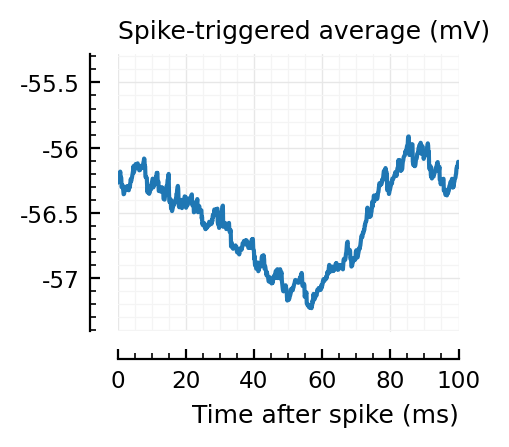

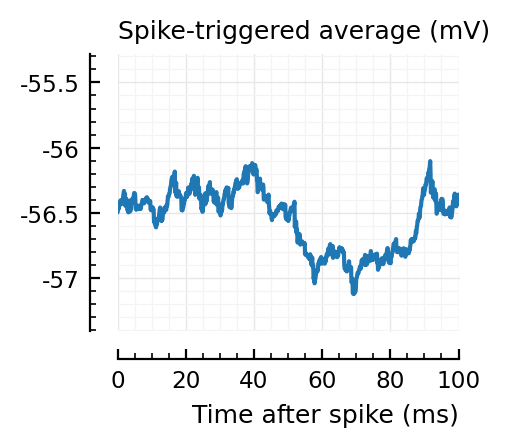

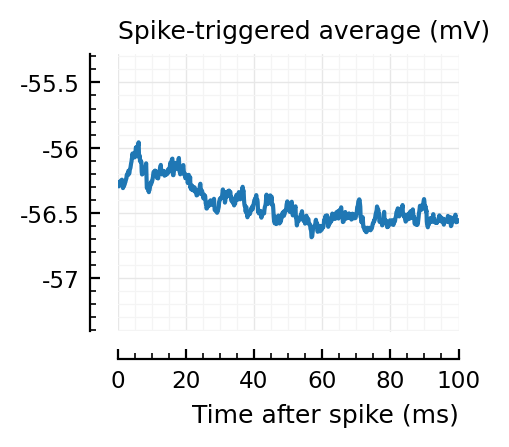

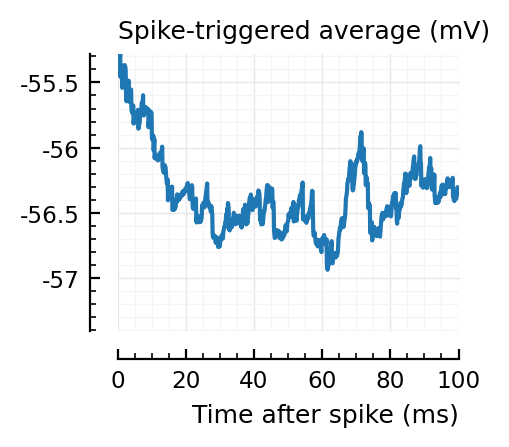

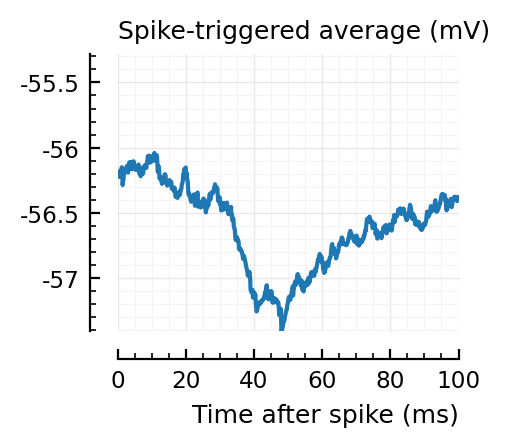

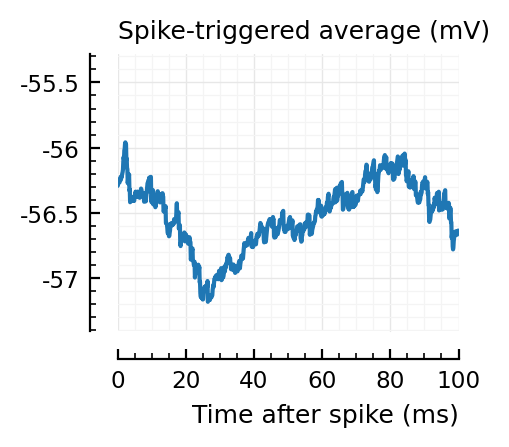

In [16]:
STAs = [calc_STA(v, s.spike_times[n], p) for n in signif_unconn]
ylim = [minimum([minimum(S) for S in STAs]), maximum([maximum(S) for S in STAs])] ./ mV
for n in signif_unconn
    _, ax = plt.subplots(figsize=(2.2, 1.8))
    plotSTA(v, s.spike_times[n], p; ax, ylim)
end

## New shuffle seed

We expect 2/6 (so 2 / 40 tested, i.e. 5%) to change, depending on shuffle.

So let's try another test.  
We do need to set the rng seed manually as the test sets it for reproducibility.

In [63]:
p2 = @set p.evaluation.rngseed = 1;

In [64]:
perf2 = evaluate_conntest_perf(v, ii.spiketrains, p2);

Testing connections: 100%|██████████████████████████████| Time: 0:01:04


In [65]:
perf2.detection_rates

(TPR_exc = 0.115, TPR_inh = 1, FPR = 0.125)

In [66]:
signif_unconn2 = ii.unconnected_neurons[findall(perf2.p_values.unconn .< p.evaluation.α)]

5-element Vector{Int64}:
  4
 14
 16
 22
 37

In [67]:
signif_unconn

6-element Vector{Int64}:
  4
  5
 14
 16
 22
 37

So all except `5` are common between both shuffle seeds.

## Paths

Let's start by finding the shortest path of each of those significant-but-not-directly-connected neurons to our target neuron.

Breadth first search.

In [17]:
function shortest_path(start::Int, target::Int, outputs::Dict{Int, Vector{Int}} = s.output_neurons)
    paths = Deque{Vector{Int}}()
    push!(paths, [start])
    while true
        path = popfirst!(paths)
        if last(path) == target
            return path
        end
        new_paths = [[path..., o] for o in outputs[last(path)] if o ∉ path]
        push!(paths, new_paths...)
    end
end;

In [18]:
for n in signif_unconn
    println(shortest_path(n, m))
end

[4, 66, 1]
[5, 66, 1]
[14, 831, 1]
[16, 169, 1]
[22, 565, 1]
[37, 11, 1]


So they are all one hop away.

## Expected number of hops

What is the overall distribution of shortest path lengths to this neuron?

This is a bit slow using the above method.  
So googling → https://www.wikiwand.com/en/Floyd–Warshall_algorithm, which finds all shortest paths in an adjacency matrix.

In [53]:
function shortest_distances(A)
    pre_post_pairs = Tuple.(findall(A))
    N = size(A)[1]
    inf = N
    dist = fill(inf, (N, N))
    for (m,n) in pre_post_pairs
        dist[m,n] = 1
    end
    for n in 1:N
        dist[n,n] = 0
    end
    for k in 1:N
        for i in 1:N
            for j in 1:N
                dk = dist[i,k] + dist[k,j]  # distance of path through k
                if dist[i,j] > dk
                    dist[i,j] = dk
                end
            end
        end
    end
    return dist
end;

In [54]:
A = s.is_connected
@time D = shortest_distances(A)

  9.155121 seconds (132.96 k allocations: 15.890 MiB, 0.97% compilation time)


1000×1000 Matrix{Int64}:
 0  3  3  2  2  3  2  2  1  1  2  2  1  …  3  2  2  3  2  2  2  2  2  2  2  1
 2  0  2  2  2  2  2  2  2  2  3  2  2     3  2  2  2  3  3  3  2  2  2  2  2
 2  2  0  2  2  2  2  2  3  3  1  2  3     3  2  2  2  2  2  2  2  2  2  3  2
 2  2  2  0  2  2  2  2  2  2  3  2  3     1  3  3  2  2  1  2  3  2  2  3  2
 2  1  2  2  0  2  2  3  3  1  2  2  2     2  1  2  2  2  3  2  2  3  2  2  3
 2  1  2  2  3  0  2  2  2  2  2  2  2  …  3  3  3  2  3  3  3  2  2  3  3  3
 2  2  2  2  2  2  0  2  2  2  2  2  2     2  2  2  2  2  2  2  2  2  3  3  2
 2  2  2  1  2  2  2  0  2  2  2  2  2     2  2  2  2  2  2  2  2  2  2  2  3
 2  2  2  2  2  3  3  2  0  2  1  2  2     2  2  2  2  2  2  3  3  2  2  2  1
 2  2  2  2  2  2  3  2  2  0  2  2  2     2  2  2  2  2  2  2  2  2  2  2  2
 1  2  2  2  2  2  2  2  2  2  0  1  2  …  2  1  2  3  2  2  2  3  2  2  2  2
 3  2  2  2  2  2  2  2  2  2  2  0  3     2  2  3  2  2  2  1  2  2  2  2  2
 2  3  2  2  2  2  1  3  3  3  2  2  0 

So to answer the question (overall distribution of path lengths to our recorded neuron):

In [77]:
distances = D[:, m];
deleteat!(distances, m);  # Remove distance to self ("0")

In [78]:
cm = countmap(distances)

Dict{Int64, Int64} with 3 entries:
  2 => 733
  3 => 230
  1 => 36

36 neurons are directly connected. This corresponds with:

In [82]:
ii.num_inputs

(exc = 26, inh = 10)

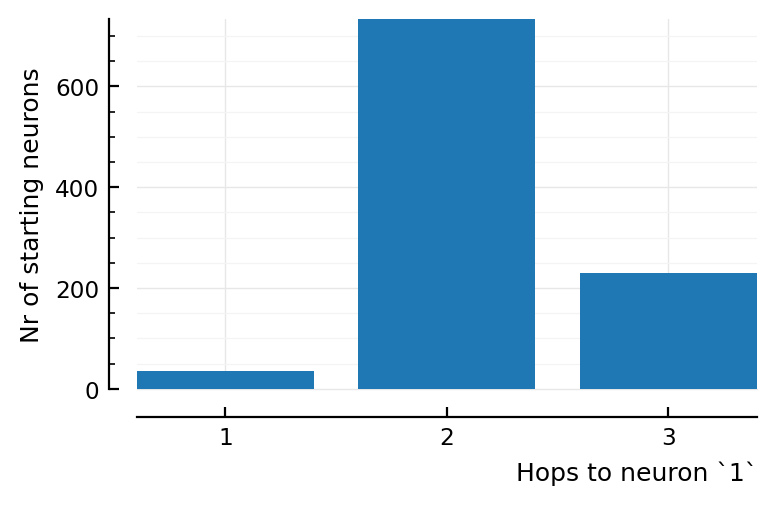

In [95]:
hops = collect(keys(cm))
nr_neurons = collect(values(cm))
_, ax = plt.subplots()
ax.bar(hops, nr_neurons)
set(ax, xlabel = "Hops to neuron `$m`", ylabel = "Nr of starting neurons", xminorticks = false)
ax.set_xticks(hops);  # `set` sets its own xticks

So most neurons have only one neuron in between; and the rest only two.
No neurons have more than that.

For the whole network (all-to-all):

In [90]:
dist_matrix_as_vector = reshape(D, prod(size(D)));
cm_full = countmap(dist_matrix_as_vector)
delete!(cm_full, 0)

Dict{Int64, Int64} with 3 entries:
  2 => 759845
  3 => 199561
  1 => 39594

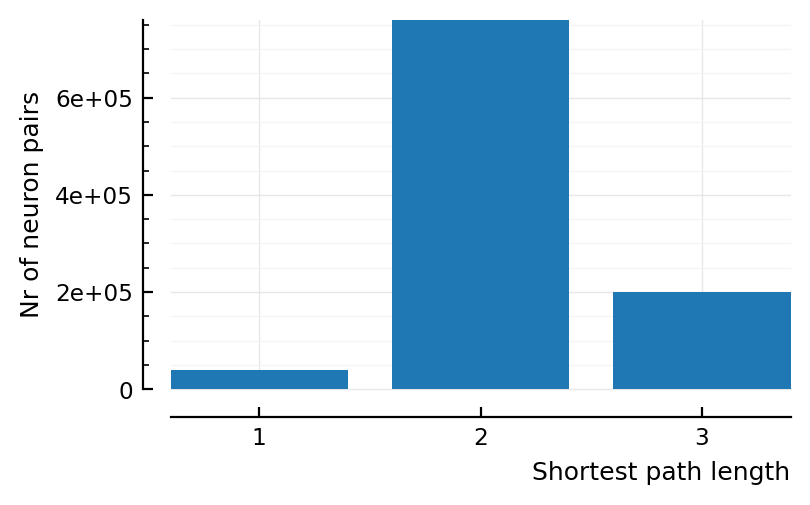

In [96]:
hops = collect(keys(cm_full))
nr_neurons = collect(values(cm_full))
_, ax = plt.subplots()
ax.bar(hops, nr_neurons)
set(ax, xlabel = "Shortest path length", ylabel = "Nr of neuron pairs", xminorticks = false)
ax.set_xticks(hops);  # `set` sets its own xticks

Same conclusions when looking at all neurons as target as when only looking at neuron `1` as target: most have just one neuron in between, the rest only two, no paths longer than 3 hops / synapses.

So in other words, our detected-but-not-connected are not special in that they only have one neuron in between.

Why are they still detected?

-- and mostly consistently so between shuffle rng seeds.

STAs are mostly downwards. Are the in-between neurons inhibitory?

## In between neuron type

In [102]:
paths = shortest_path.(signif_unconn, m)
in_between_neuron = [p[2] for p in paths if length(p) == 3]

6-element Vector{Int64}:
  66
  66
 831
 169
 565
  11

In [103]:
[s.neuron_type[n] for n in in_between_neuron]

6-element Vector{Symbol}:
 :exc
 :exc
 :inh
 :exc
 :exc
 :exc

So no.

Ah but we found only one shortest path. There are likely multiple.

Maybe the detected ones have *more* inhibitory in between, or stronger connections, or higher firing neurons.
So we could compare these measures between a detected and an undetected unconncted neuron.

## All paths

Let's start with all paths of length 2 (edges; so 3 neurons, including start and target).

In [118]:
function all_paths_of_length(k::Int, start::Int, target::Int, outputs::Dict{Int, Vector{Int}} = s.output_neurons)
    paths = [[start]]
    for i in 1:k
        newpaths = []
        for path in paths
            push!(newpaths, [[path..., o] for o in outputs[last(path)]]...)
        end
        paths = newpaths
    end
    return [p for p in paths if last(p) == target]
end;

In [130]:
insignif_unconn = [n for n in tested_unconn if n ∉ signif_unconn]
show(insignif_unconn)

[2, 3, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43]

In [124]:
signif_unconn

6-element Vector{Int64}:
  4
  5
 14
 16
 22
 37

In [131]:
all_paths_of_length(2, signif_unconn[1], m)

3-element Vector{Vector{Int64}}:
 [4, 66, 1]
 [4, 516, 1]
 [4, 928, 1]

In [133]:
all_paths_of_length(2, insignif_unconn[1], m)

3-element Vector{Vector{Int64}}:
 [2, 70, 1]
 [2, 418, 1]
 [2, 831, 1]

Now do this for all tested neurons, and get the type of the in-between neurons.

## Compare between detected (false positive) and not detected (true negative)

Start simple: number of paths of length 2, for each.

In [227]:
macro plothists(expr, title = "", bins = 10)
    return quote
        vals_sig = [$expr for n in signif_unconn]
        vals_insig = [$expr for n in insignif_unconn]
        plt.hist([vals_sig, vals_insig], $bins, align="left",
                 label = ["Detected as connected", "Not detected as connected"])
        plt.legend()
        plt.xlabel($title, loc="center")
    end
end;

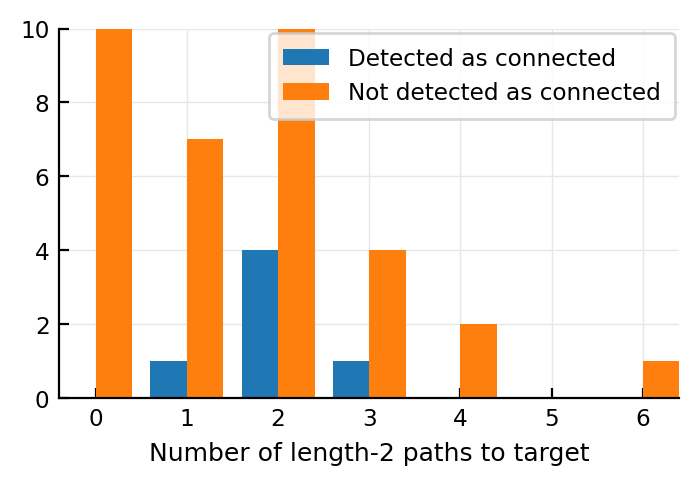

In [235]:
@plothists length(all_paths_of_length(2, n, m)) "Number of length-2 paths to target" 0:7;

No big diff it seems. The detected maybe have more paths.

Next, nr of inhibitory in between.

In [166]:
type_of_in_between_neuron(path) = s.neuron_type[path[2]]

num_inh_in_between(start_n) =
    count([type_of_in_between_neuron(p) for p in all_paths_of_length(2, start_n, m)] .== :inh);

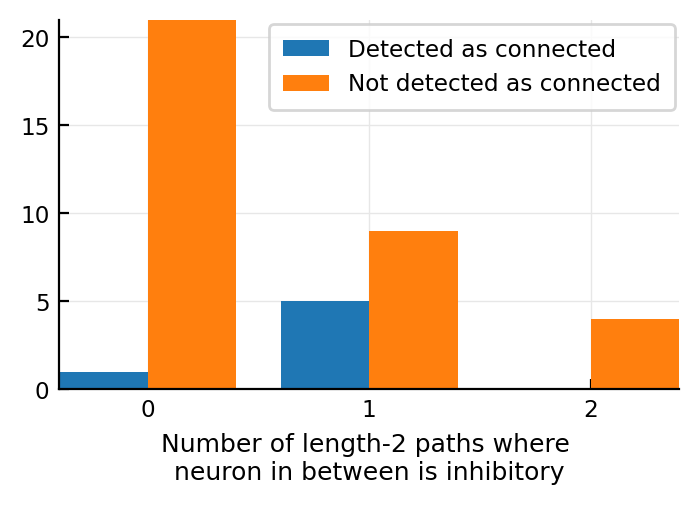

In [243]:
@plothists(num_inh_in_between(n), "Number of length-2 paths where \nneuron in between is inhibitory", 0:3)
plt.xticks(0:2);

~~So no, not more inhibitory in between; on the contrary, there's other neurons with more inhibitory in between, that didn't get detected.~~  
When I actually plotted it, I did see diff :)

The detected-as-connected neurons have more inhibitory neurons as in-between to our target neuron.

Next, firing rates.

In [233]:
firing_rate_of_in_between_neuron(path) = s.spike_rates[path[2]]
mean_or_zero(x) = isempty(x) ? 0 : mean(x)
mean_fr_in_between(n) =
    mean_or_zero([firing_rate_of_in_between_neuron(p) for p in all_paths_of_length(2, n, m)]);

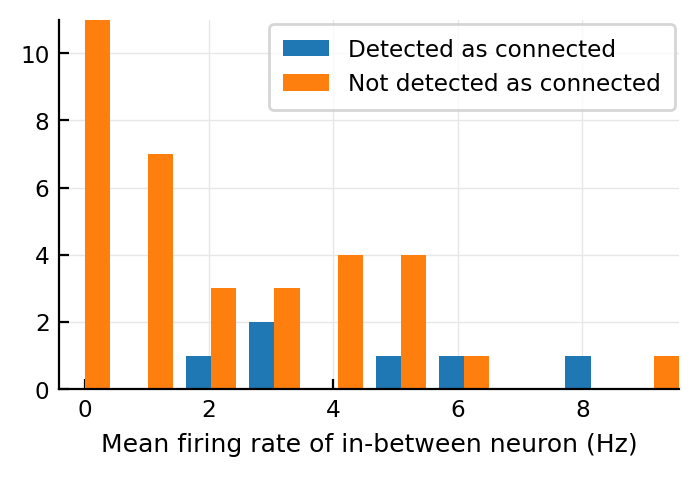

In [244]:
@plothists mean_fr_in_between(n) "Mean firing rate of in-between neuron (Hz)";

Again, seems like a bit higher firing rate.

## STAs of non-detected

We repeat the STAs of the detected unconnected here..

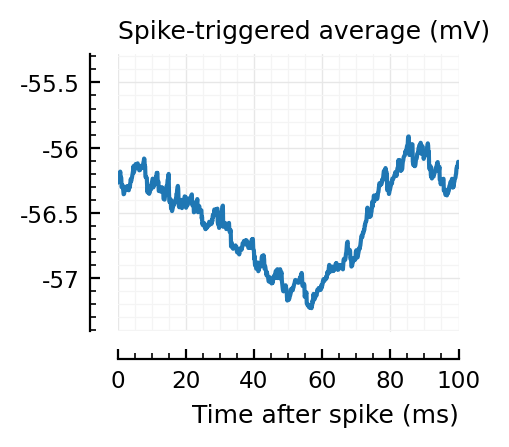

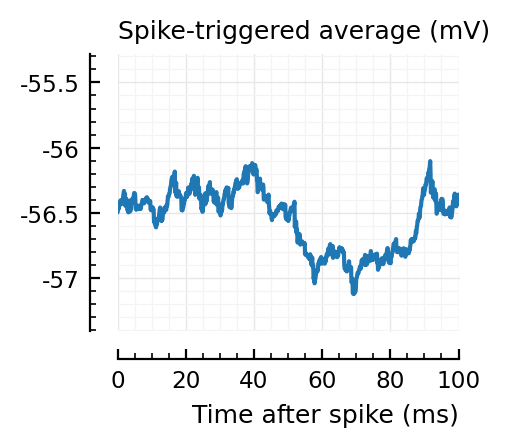

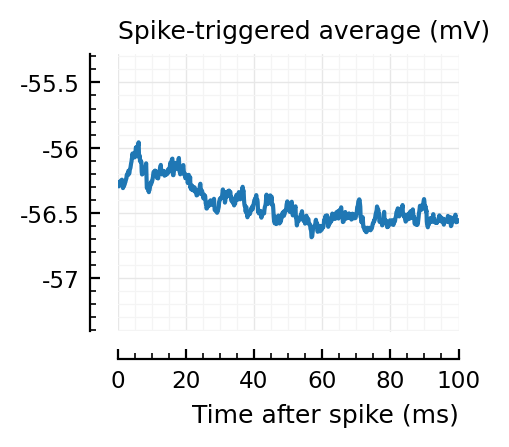

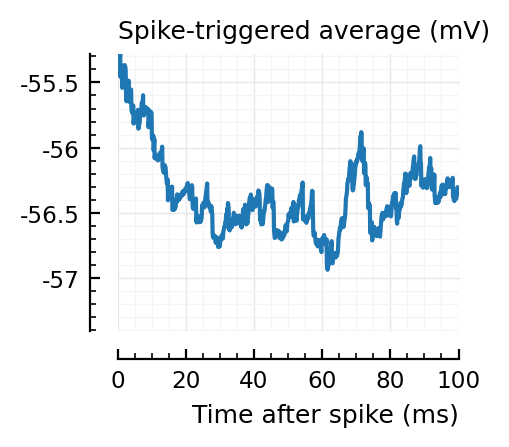

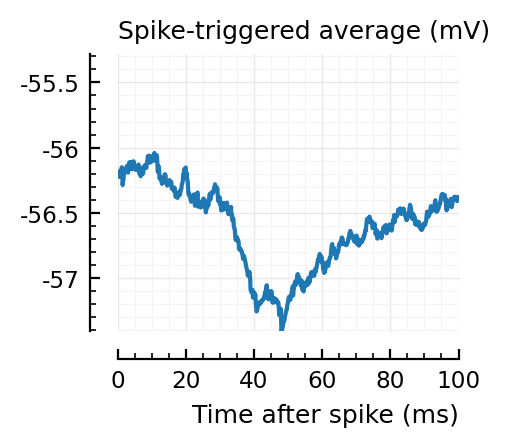

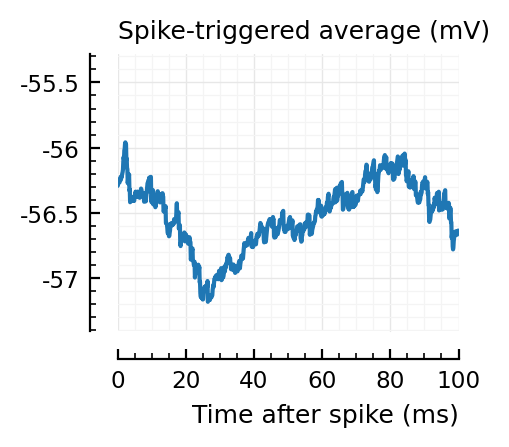

In [245]:
STAs = [calc_STA(v, s.spike_times[n], p) for n in signif_unconn]
ylim = [minimum([minimum(S) for S in STAs]), maximum([maximum(S) for S in STAs])] ./ mV
for n in signif_unconn
    _, ax = plt.subplots(figsize=(2.2, 1.8))
    plotSTA(v, s.spike_times[n], p; ax, ylim)
end

..to then compare them with some STAs of the non-detected unconnected:

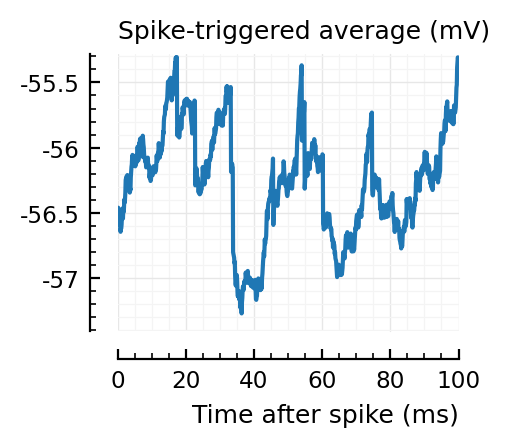

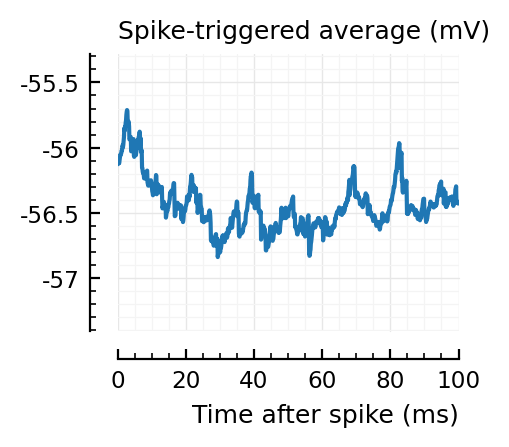

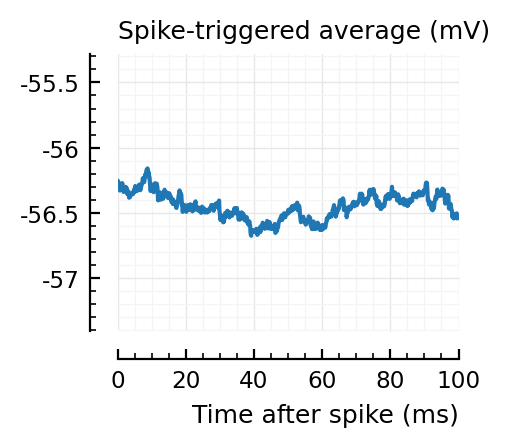

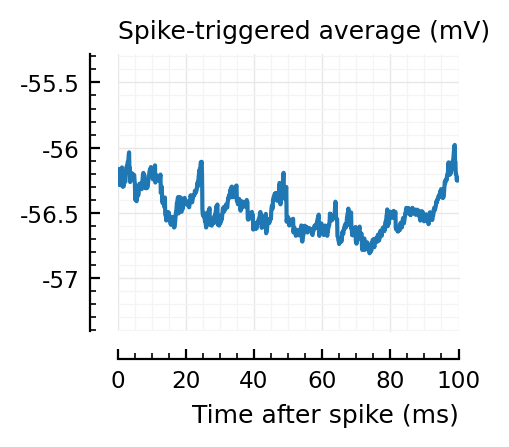

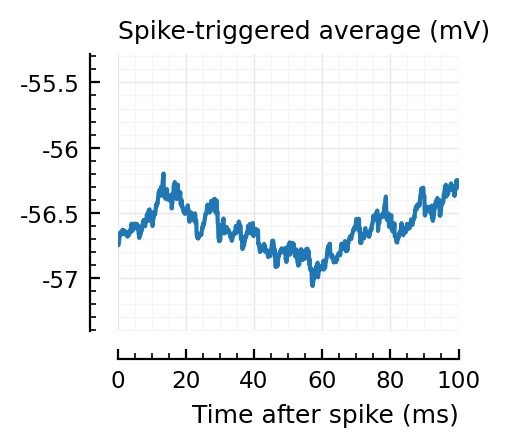

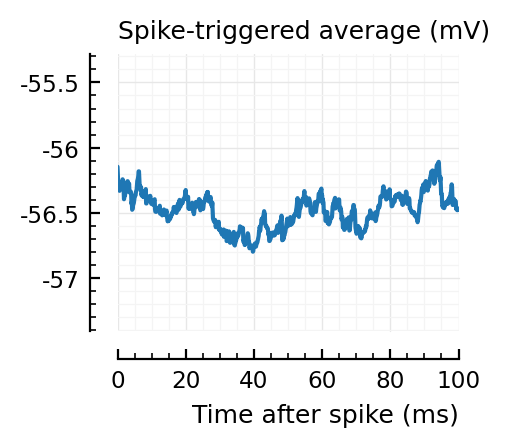

In [246]:
for n in insignif_unconn[1:6]
    _, ax = plt.subplots(figsize=(2.2, 1.8))
    plotSTA(v, s.spike_times[n], p; ax, ylim)
end

Strangely, these STAs do not seem much smaller than the detected ones..

The first one is very high. What was it's p-value?

In [250]:
perf.p_values.unconn[1]

0.55

Check (we repeat this as it the shuffle is different each time):

In [266]:
mean([test_connection(v, s.spike_times[ii.unconnected_neurons[1]], p) for i in 1:10])

0.561

Quite interesting.  
Here the value of the shuffle test (instead of looking at the absolute STA height values) comes up.

Maybe it is so high because the neuron has only few spikes (and thus a noisy STA).

In [267]:
s.spike_rates[ii.unconnected_neurons[1]]

0.242

Indeed, quite low :)